# Lab 6:  Neural Networks for Music Classification

In addition to the concepts in the [MNIST neural network demo](./mnist_neural.ipynb), in this lab, you will learn to:
* Load a file from a URL
* Extract simple features from audio samples for machine learning tasks such as speech recognition and classification
* Build a simple neural network for music classification using these features
* Use a callback to store the loss and accuracy history in the training process
* Optimize the learning rate of the neural network

To illustrate the basic concepts, we will look at a relatively simple music classification problem.  Given a sample of music, we want to determine which instrument (e.g. trumpet, violin, piano) is playing.  This dataset was generously supplied by [Prof. Juan Bello](http://steinhardt.nyu.edu/faculty/Juan_Pablo_Bello) at NYU Stenihardt  and his former PhD student Eric Humphrey (now at Spotify).  They have a complete website dedicated to deep learning methods in music informatics:

http://marl.smusic.nyu.edu/wordpress/projects/feature-learning-deep-architectures/deep-learning-python-tutorial/

You can also check out Juan's <a href="http://www.nyu.edu/classes/bello/ACA.html">course</a>.



## Loading the Keras package
We begin by loading keras and the other packages

In [1]:
import keras

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Audio Feature Extraction with Librosa

The key to audio classification is to extract the correct features. In addition to `keras`, we will need the `librosa` package.  The `librosa` package in python has a rich set of methods extracting the features of audio samples commonly used in machine learning tasks such as speech recognition and sound classification. 

Installation instructions and complete documentation for the package are given on the [librosa main page](https://librosa.github.io/librosa/).  On most systems, you should be able to simply use:

    pip install -u librosa
    
For Unix, you may need to load some additional packages:

    sudo apt-get install build-essential
    sudo apt-get install libxext-dev python-qt4 qt4-dev-tools
    pip install librosa
    
After you have installed the package, try to import it.

In [3]:
import librosa
import librosa.display
import librosa.feature

In this lab, we will use a set of music samples from the website:

http://theremin.music.uiowa.edu

This website has a great set of samples for audio processing.  Look on the web for how to use the `requests.get` and `file.write` commands to load the file at the URL provided into your working directory.

You can play the audio sample by copying the file to your local machine and playing it on any media player.  If you listen to it you will hear a soprano saxaphone (with vibrato) playing four notes (C, C#, D, Eb).

In [4]:
import requests
fn = "SopSax.Vib.pp.C6Eb6.aiff"
url = "http://theremin.music.uiowa.edu/sound files/MIS/Woodwinds/sopranosaxophone/"+fn
ff=requests.get(url)
open (fn,"wb").write(ff.content)
# TODO:  Load the file from url and save it in a file under the name fn

1418242

Next, use `librosa` command `librosa.load` to read the audio file with filename `fn` and get the samples `y` and sample rate `sr`.

In [5]:
# TODO
# y, sr = ...
y, sr = librosa.load(fn , sr=48100)

Extracting features from audio files is an entire subject on its own right.  A commonly used set of features are called the Mel Frequency Cepstral Coefficients (MFCCs).  These are derived from the so-called mel spectrogram which is something like a regular spectrogram, but the power and frequency are represented in log scale, which more naturally aligns with human perceptual processing.  You can run the code below to display the mel spectrogram from the audio sample.

You can easily see the four notes played in the audio track.  You also see the 'harmonics' of each notes, which are other tones at integer multiples of the fundamental frequency of each note.

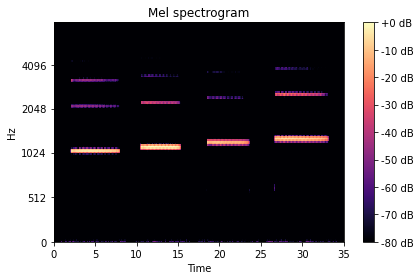

In [6]:
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
librosa.display.specshow(librosa.amplitude_to_db(S,ref=np.max),
                         y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

## Downloading the Data

Using the MFCC features described above, Eric Humphrey and Juan Bellow have created a complete data set that can used for instrument classification.  Essentially, they collected a number of data files from the website above.  For each audio file, the segmented the track into notes and then extracted 120 MFCCs for each note.  The goal is to recognize the instrument from the 120 MFCCs.  The process of feature extraction is quite involved.  So, we will just use their processed data provided at:

https://github.com/marl/dl4mir-tutorial/blob/master/README.md

Note the password.  Load the four files into some directory, say  `instrument_dataset`.  Then, load them with the commands.

In [7]:
data_dir = 'instrument_dataset/'
Xtr = np.load(data_dir+'uiowa_train_data.npy')
ytr = np.load(data_dir+'uiowa_train_labels.npy')
Xts = np.load(data_dir+'uiowa_test_data.npy')
yts = np.load(data_dir+'uiowa_test_labels.npy')

Looking at the data files:
* What are the number of training and test samples?
* What is the number of features for each sample?
* How many classes (i.e. instruments) are there per class.


In [8]:
# TODO
print('number of  training samples is %d and test samples is %d'% (len(Xtr),len(Xts)))
print ('number of features for each sample %d'% (Xtr.shape[1]))
print('classes of training : %d'%(len(np.unique(ytr))))
print('classes of testing : %d'%(len(np.unique(yts))))

number of  training samples is 66247 and test samples is 14904
number of features for each sample 120
classes of training : 10
classes of testing : 10


Before continuing, you must scale the training and test data, `Xtr` and `Xts`.  Compute the mean and std deviation of each feature in `Xtr` and create a new training data set, `Xtr_scale`, by subtracting the mean and dividing by the std deviation.  Also compute a scaled test data set, `Xts_scale` using the mean and std deviation learned from the training data set.

In [9]:
# TODO Scale the training and test matrices
# Xtr_scale = ...
# Xts_scale = ...
Xtr_mean=np.mean(Xtr,axis=0)
Xtr_std=np.std(Xtr,axis=0)
Xtr_scale=(Xtr - Xtr_mean[None, :])/Xtr_std[None, :]
Xts_scale=(Xts - Xtr_mean[None, :])/Xtr_std[None, :]
print(Xtr_scale)
print(Xts_scale)

[[-0.31827517 -0.32885595 -0.29351324 ... -0.36022673 -0.25311227
  -0.41772567]
 [-0.31018965 -0.2727317  -0.2771818  ... -0.17807889  0.22098027
  -0.04118938]
 [-0.27996699 -0.30067912 -0.26579675 ... -0.22750957  0.43279931
  -0.00953712]
 ...
 [-0.70541453 -0.70723946 -0.70942862 ...  3.33693492  4.20324336
   3.70233809]
 [-0.71897237 -0.71054126 -0.71014551 ...  3.61543866  6.39878693
   3.31839917]
 [-0.72390302 -0.7118741  -0.70965863 ...  1.07922697  1.84041084
   1.42883157]]
[[-0.21750643 -0.21681385 -0.22310685 ... -0.68837059 -0.80603516
  -0.72767992]
 [-0.23309243 -0.23444571 -0.23947694 ... -0.73434555 -0.71418557
  -0.791695  ]
 [-0.16197075 -0.20414146 -0.22111234 ... -0.66818614 -0.80244538
  -0.68702929]
 ...
 [-0.66945232 -0.66272087 -0.66150228 ... -0.74286231 -0.74274835
  -0.81456784]
 [-0.66689074 -0.66199011 -0.66236822 ... -0.59806106 -0.64959124
  -0.54035891]
 [-0.66550011 -0.66405765 -0.66227782 ... -0.55623913 -0.55268092
  -0.63606318]]


In [10]:
from keras.models import Model, Sequential
from keras.layers import Dense, Activation

In [11]:
# TODO clear session
from keras import backend as k
k.clear_session()

In [12]:
# TODO: construct the model
nh=256
no_in=Xtr_scale.shape[1]
no_out=int(np.max(ytr)+1)
model=Sequential()
model.add(Dense(units=nh,input_shape=(no_in,),activation='sigmoid',name='hidden'))
model.add(Dense(units=no_out,activation='softmax',name='output'))

In [13]:
# TODO:  Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden (Dense)              (None, 256)               30976     
                                                                 
 output (Dense)              (None, 10)                2570      
                                                                 
Total params: 33,546
Trainable params: 33,546
Non-trainable params: 0
_________________________________________________________________


To keep track of the loss history and validation accuracy, we will use a *callback* function as described in [Keras callback documentation](https://keras.io/callbacks/).  A callback is a class that is passed to the `fit` method.  Complete the `LoadHistory` callback class below to save the loss and validation accuracy.

In [14]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        # TODO:  Create two empty lists, self.loss and self.val_acc
        self.loss = []
        self.val_acc = []
       
    def on_batch_end(self, batch, logs={}):
        # TODO:  This is called at the end of each batch.  
        # Add the loss in logs.get('loss') to the loss list
        self.loss.append(logs.get('loss'))
    def on_epoch_end(self, epoch, logs):
        # TODO:  This is called at the end of each epoch.  
        # Add the test accuracy in logs.get('val_acc') to the val_acc list
       
        self.val_acc.append(logs.get('val_acc'))

# Create an instance of the history callback
history_cb = LossHistory()

Create an optimizer and compile the model.  Select the appropriate loss function and metrics.  For the optimizer, use the Adam optimizer with a learning rate of 0.001

In [15]:
# TODO
# opt = ...
# model.compile(...)
from tensorflow.keras import optimizers
optim = optimizers.Adam(learning_rate=0.001)
model.compile(optim,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

Fit the model for 10 epochs using the scaled data for both the training and validation.  Use the `validation_data` option to pass the test data.  Also, pass the callback class create above.  Use a batch size of 100.  Your final accuracy should be >99%.

In [16]:
# TODO
batch_size = 100
hist = model.fit(Xtr_scale, ytr, epochs= 10, batch_size= batch_size , validation_data= (Xts_scale, yts), callbacks=[history_cb])

Epoch 1/10
663/663 [==============================] - 1s 1ms/step - loss: 0.3553 - accuracy: 0.9030 - val_loss: 0.1761 - val_accuracy: 0.9532
Epoch 2/10
663/663 [==============================] - 1s 1ms/step - loss: 0.0999 - accuracy: 0.9759 - val_loss: 0.0889 - val_accuracy: 0.9755
Epoch 3/10
663/663 [==============================] - 1s 1ms/step - loss: 0.0596 - accuracy: 0.9853 - val_loss: 0.0574 - val_accuracy: 0.9865
Epoch 4/10
663/663 [==============================] - 1s 1ms/step - loss: 0.0419 - accuracy: 0.9894 - val_loss: 0.0478 - val_accuracy: 0.9868
Epoch 5/10
663/663 [==============================] - 1s 1ms/step - loss: 0.0321 - accuracy: 0.9917 - val_loss: 0.0433 - val_accuracy: 0.9881
Epoch 6/10
663/663 [==============================] - 1s 1ms/step - loss: 0.0254 - accuracy: 0.9933 - val_loss: 0.0338 - val_accuracy: 0.9901
Epoch 7/10
663/663 [==============================] - 1s 1ms/step - loss: 0.0209 - accuracy: 0.9946 - val_loss: 0.0299 - val_accuracy: 0.9914
Epoch 

Plot the validation accuracy saved in the `history_cb`. This gives one accuracy value per epoch.  You should see that the validation accuracy saturates at a little higher than 99%.  After that it "bounces around" due to the noise in the stochastic gradient descent.

Text(0.5, 1.0, 'Validation accuracy for each Epoch')

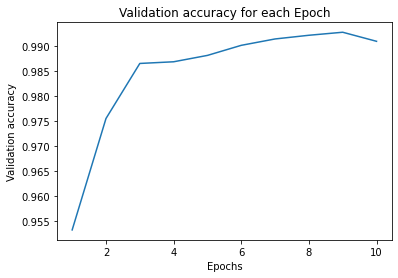

In [17]:
# TODO
epochs=np.arange(1,11)
plt.plot(epochs,hist.history['val_accuracy'])
plt.ylabel('Validation accuracy')
plt.xlabel('Epochs')
plt.title('Validation accuracy for each Epoch')

Plot the loss values saved in the `history_cb` class.  Use the `semilogy` plot.  There is one loss value per step.  But, plot the x-axis in epochs.  Note that the epoch in step `i` is `epoch = i*batch_size/ntr` where `batch_size` is the batch_size and `ntr` is the total number of training samples.

[0.35533893 0.09987517 0.05955257 0.04186201 0.03209239 0.02542815
 0.02090845 0.01747671 0.01493273 0.01297856]


Text(0.5, 0, 'Loss')

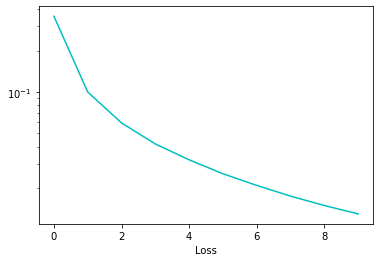

In [18]:
# TODO
hist=np.array(hist.history['loss'])
print(hist)
plt.semilogy(hist,'c')
plt.xlabel('Loss')

## Optimizing the Learning Rate

One challenge in training neural networks is the selection of the learning rate.  Rerun the above code, trying three learning rates as shown in the vector `rates`.  For each learning rate:
* clear the session
* construct the network
* select the optimizer.  Use the Adam optimizer with the appropriate learrning rate.
* train the model
* save the accuracy and losses

In [19]:
import tensorflow.keras.backend as K
rates = [0.01,0.001,0.0001]
batch_size = 100
loss_hist = []
acc_hist=[]


# TODO
for lr in rates:
    K.clear_session()
    nin = Xtr_scale.shape[1]  # dimension of input data
    nh = 256     # number of hidden units
    nout = int(np.max(ytr)+1)
    print(nout)
    model = Sequential()
    model.add(Dense(units=nh, input_shape=(nin,), activation='sigmoid', name='hidden'))
    model.add(Dense(units=nout, activation='softmax', name='output'))
    opt = optimizers.Adam(lr) # beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer=opt,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    hist = model.fit(Xtr_scale, ytr, epochs=20,batch_size=100, validation_data=(Xts_scale,yts))
    loss_hist.append(hist.history['loss'])
    acc_hist.append(hist.history['accuracy'])

10
Epoch 1/20
663/663 [==============================] - 1s 1ms/step - loss: 0.1095 - accuracy: 0.9658 - val_loss: 0.0553 - val_accuracy: 0.9820
Epoch 2/20
663/663 [==============================] - 1s 1ms/step - loss: 0.0322 - accuracy: 0.9897 - val_loss: 0.0285 - val_accuracy: 0.9893
Epoch 3/20
663/663 [==============================] - 1s 1ms/step - loss: 0.0205 - accuracy: 0.9931 - val_loss: 0.0429 - val_accuracy: 0.9852
Epoch 4/20
663/663 [==============================] - 1s 1ms/step - loss: 0.0204 - accuracy: 0.9938 - val_loss: 0.0597 - val_accuracy: 0.9787
Epoch 5/20
663/663 [==============================] - 1s 1ms/step - loss: 0.0174 - accuracy: 0.9944 - val_loss: 0.0651 - val_accuracy: 0.9775
Epoch 6/20
663/663 [==============================] - 1s 1ms/step - loss: 0.0129 - accuracy: 0.9957 - val_loss: 0.0223 - val_accuracy: 0.9914
Epoch 7/20
663/663 [==============================] - 1s 1ms/step - loss: 0.0116 - accuracy: 0.9962 - val_loss: 0.0444 - val_accuracy: 0.9881
Epo

Plot the loss funciton vs. the epoch number for all three learning rates on one graph.  You should see that the lower learning rates are more stable, but converge slower.

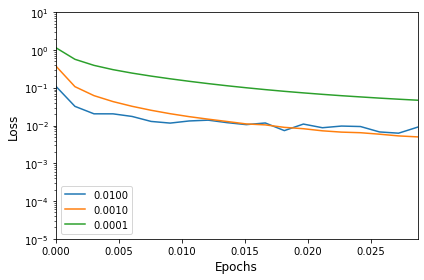

In [22]:
ntest = len(loss_hist)
ntr = Xtr.shape[0]
batch_size = 100
for it, loss in enumerate (loss_hist):
  nsteps = len(loss)
  epochs = np.arange(nsteps)*batch_size/ntr
  
  plt.semilogy(epochs,loss)
  
  rate_str = ['{0:5.4f}'.format(Ir) for Ir in rates]

plt.axis([0,np.max(epochs),1e-5,10])
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(rate_str,loc='lower left')
plt.tight_layout()
# TODO